# Exploring the Data

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MaxAbsScaler

import matplotlib.pyplot as plt
import seaborn as sns

## Get Specific Records from CSV

record columns = 'type', 'startDate', 'endDate', 'value', 'unit'


In [320]:
# selected_columns = [1, 6, 7, 4, 8]

# selected_types = ['HKQuantityTypeIdentifierActiveEnergyBurned',
#                   'HKQuantityTypeIdentifierBasalEnergyBurned',
#                   'HKQuantityTypeIdentifierDistanceWalkingRunning']

# def float_handler(amount):
#     try:
#         return np.float64(amount)
#     except ValueError:
#         return np.nan


# records_df = pd.read_csv('data/health_data.csv', usecols=selected_columns,
#                         # parse_dates=['startDate', 'endDate'],
#                         # date_format='%Y-%m-%d %H:%M:%S %z',
#                         dtype={'type': 'string', 'unit': 'string',
#                                'startDate': 'string', 'endDate': 'string'},
#                         low_memory=False, index_col=False,
#                         converters={'value': float_handler}
#                         )[['type', 'startDate', 'endDate', 'value', 'unit']]

# records_df.head()

### Get daily sums for each data point

In [5]:
# selected_df = records_df.copy()
# selected_df = selected_df[selected_df['type'].isin(selected_types)].sort_values(by='startDate').reset_index(drop=True)

# # add simple date column
# selected_df['date'] = selected_df['startDate'].str[:10]

# # get daily sums
# sum_df = selected_df.groupby(by=['date', 'type', 'unit'])['value'].sum().reset_index()

# sum_df.to_csv('data/daily_sums.csv', index=False)


## Explore Data

### Imports

In [33]:
sum_df = pd.read_csv('data/daily_sums.csv',
                     date_format='%Y-%m-%d',
                     parse_dates=['date'],
                     dtype={'type': 'string', 'unit': 'string', 'value': np.float64},
                     low_memory=False, index_col=False)

sum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5258 entries, 0 to 5257
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5258 non-null   datetime64[ns]
 1   type    5258 non-null   string        
 2   unit    5258 non-null   string        
 3   value   5258 non-null   float64       
dtypes: datetime64[ns](1), float64(1), string(2)
memory usage: 164.4 KB


In [47]:
year_starts = [np.datetime64(dt) for dt in ['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01', '2024-01-01', '2025-01-01']]

distance_travelled = sum_df[sum_df['type'] == 'HKQuantityTypeIdentifierDistanceWalkingRunning']
distance_travelled = distance_travelled.set_index('date')[['value']].rename(columns={'value': 'km'})

basal_energy = sum_df[sum_df['type'] == 'HKQuantityTypeIdentifierBasalEnergyBurned'].set_index('date')[['value']]
active_energy = sum_df[sum_df['type'] == 'HKQuantityTypeIdentifierActiveEnergyBurned'].set_index('date')[['value']]
total_cals = basal_energy.add(active_energy, fill_value=0).rename(columns={'value': 'calories'})[1:]
total_cals = total_cals[total_cals['calories'] > 1300]

display(distance_travelled.head())
display(total_cals.head())

km
date                
2019-04-26  0.132720
2019-04-27  0.526320
2019-04-28  1.913160
2019-04-29  3.551862
2019-04-30  5.939268

calories
date                
2020-12-30  1731.292
2020-12-31  2105.775
2021-01-01  2374.592
2021-01-02  2053.541
2021-01-03  1798.937

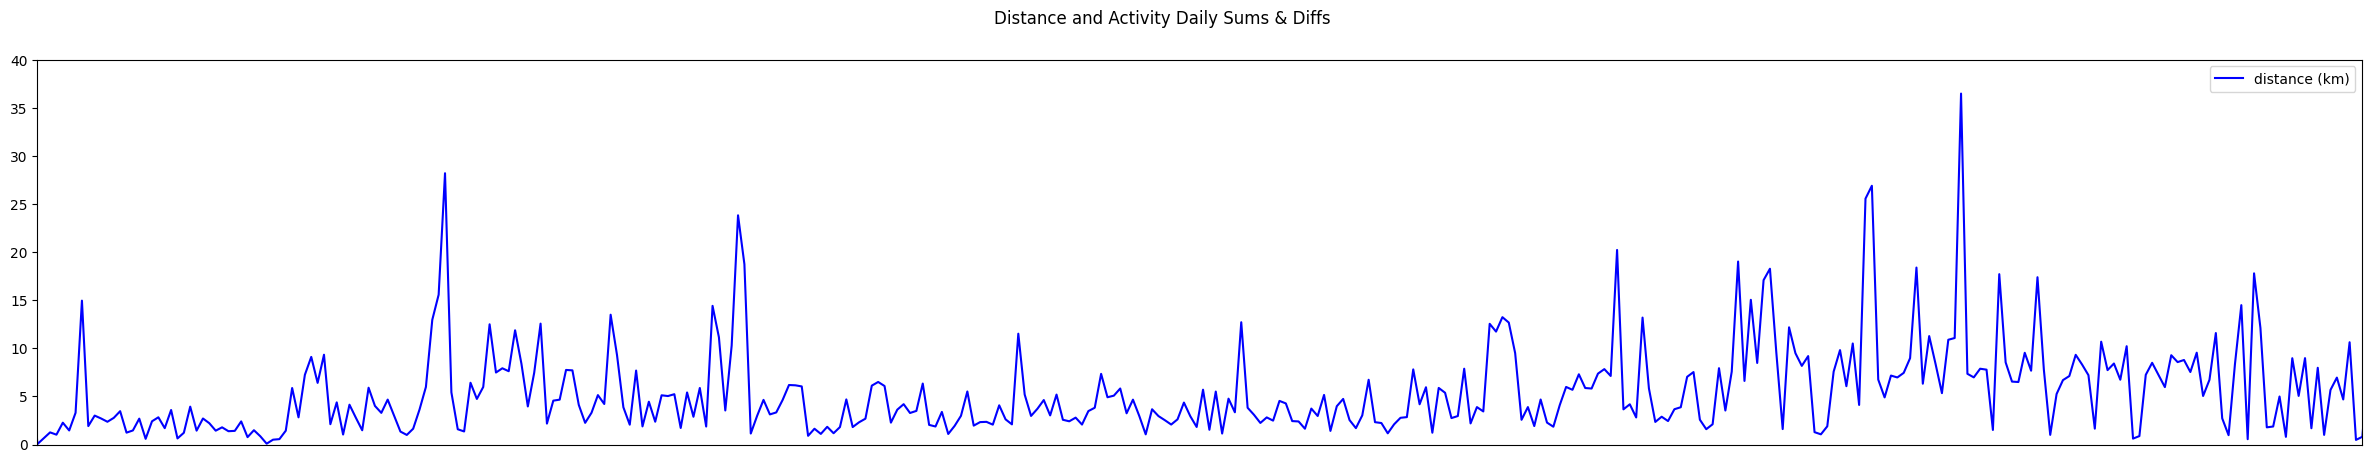

In [214]:
distance_diff = distance_travelled.diff().dropna()
cals_diff = total_cals.diff().dropna()

fig, ax = plt.subplots(figsize=(30, 5))
ax.plot(distance_travelled, color='blue', label='distance (km)')
# ax.plot(distance_diff, color='cornflowerblue', label='distance diff', linewidth=0.5)
ax.set_xticks([])
ax.set_ybound(0, 40)
ax.set_xbound(np.datetime64('2022-01-01'), np.datetime64('2023-01-01'))
ax.legend()

# ax[1].plot(total_cals, color='darkorange', label='total energy (cal)')
# ax[1].plot(cals_diff, color='orange', label='calories diff', linewidth=0.5)
# ax[1].set_xticks(year_starts)
# ax[1].legend()

plt.suptitle('Distance and Activity Daily Sums & Diffs')
plt.show()

#### Distance

In [ ]:
# standard devs

def plot_means_std(period, df):
    w = 1500/len(df)
    d = 800//len(df)

    fig, ax = plt.subplots(figsize=(30, 5))
    ax.bar(df.index, df['mean'], width=w, align='edge', color='lightblue')

    upperlimits = [True, False] * (len(df)//2)
    lowerlimits = [False, True] * (len(df)//2)

    ax.errorbar(df.index + np.timedelta64(d, 'D'), df['mean'],
                yerr=df['std'], uplims=upperlimits, lolims=lowerlimits,
                color='darkred', linestyle='none', elinewidth=0.5)

    ax.set_ybound(-4, 25)
    ax.set_title(f'{period} Means & Std Devs')
    plt.show()


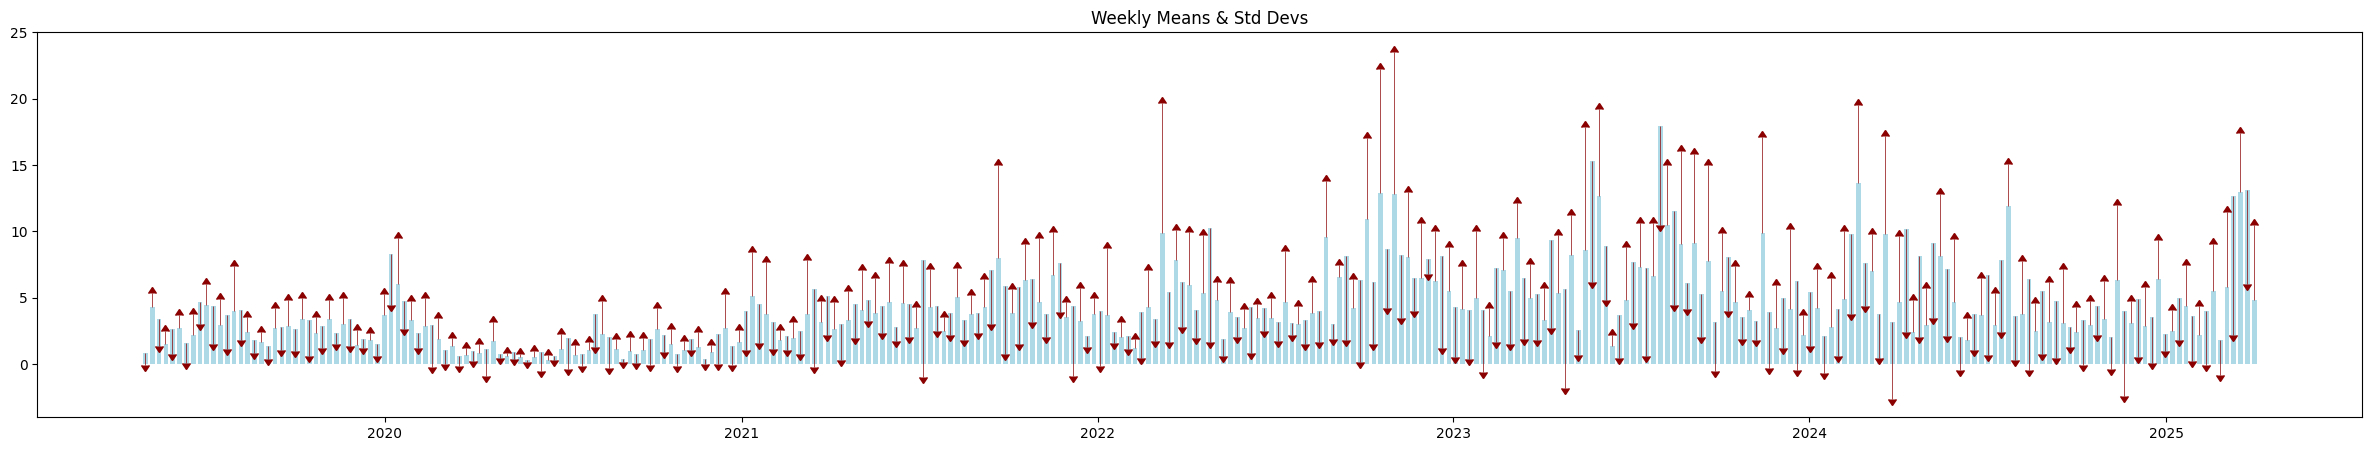

In [293]:
weekly_means = distance_travelled.resample('W').agg(['mean', 'std']).droplevel(level=0, axis=1)
plot_means_std('Weekly', weekly_means)

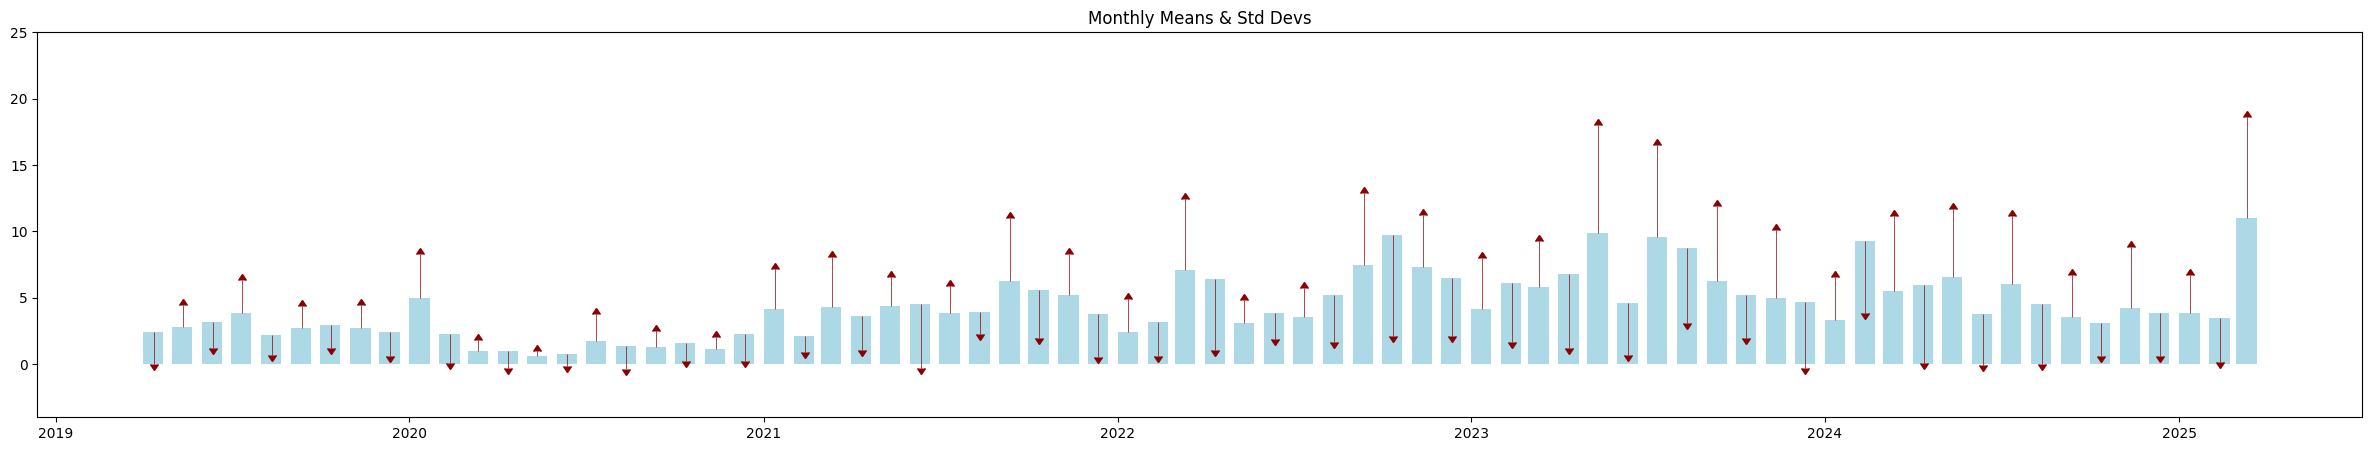

In [294]:
monthly_means = distance_travelled.resample('MS').agg(['mean', 'std']).droplevel(level=0, axis=1)
plot_means_std('Monthly', monthly_means)

In [ ]:
# remove outliers

def zscore(s, window, thresh=3, return_all=False):
    roll = s.rolling(window=window, min_periods=1, center=True)
    avg = roll.mean()
    std = roll.std(ddof=0)
    z = s.sub(avg).div(std)
    m = z.between(-thresh, thresh)

    if return_all:
        return z, avg, std, m
    return s.where(m, avg)

def plot_outliers(df, avg, m, slim_df):
    fig, ax = plt.subplots(figsize=(30,5))

    ax.plot(df, label='data', alpha=0.2)
    ax.plot(avg, label='mean')
    ax.plot(df.loc[~m, 'km'], label='outliers', marker='x', ls='', color='red')
    ax.plot(avg[~m], label='replacement', marker='o', ls='', color='green', markersize=5)
    ax.legend()
    ax.set_title('weekly outliers')
    plt.show()

def plot_slim(slim_df, df):
    fig, ax = plt.subplots(figsize=(30, 5))
    ax.plot(slim_df, color='blue', label='distance (km)')
    ax.plot(df, color='cornflowerblue', label='og distances', linewidth=0.5)
    ax.set_ybound(0, 40)
    ax.set_xbound(np.datetime64('2021-01-01'), np.datetime64('2025-01-01'))
    ax.legend()
    plt.show()

4.108956602031395 % samples removed as outliers (2 st. dvs)


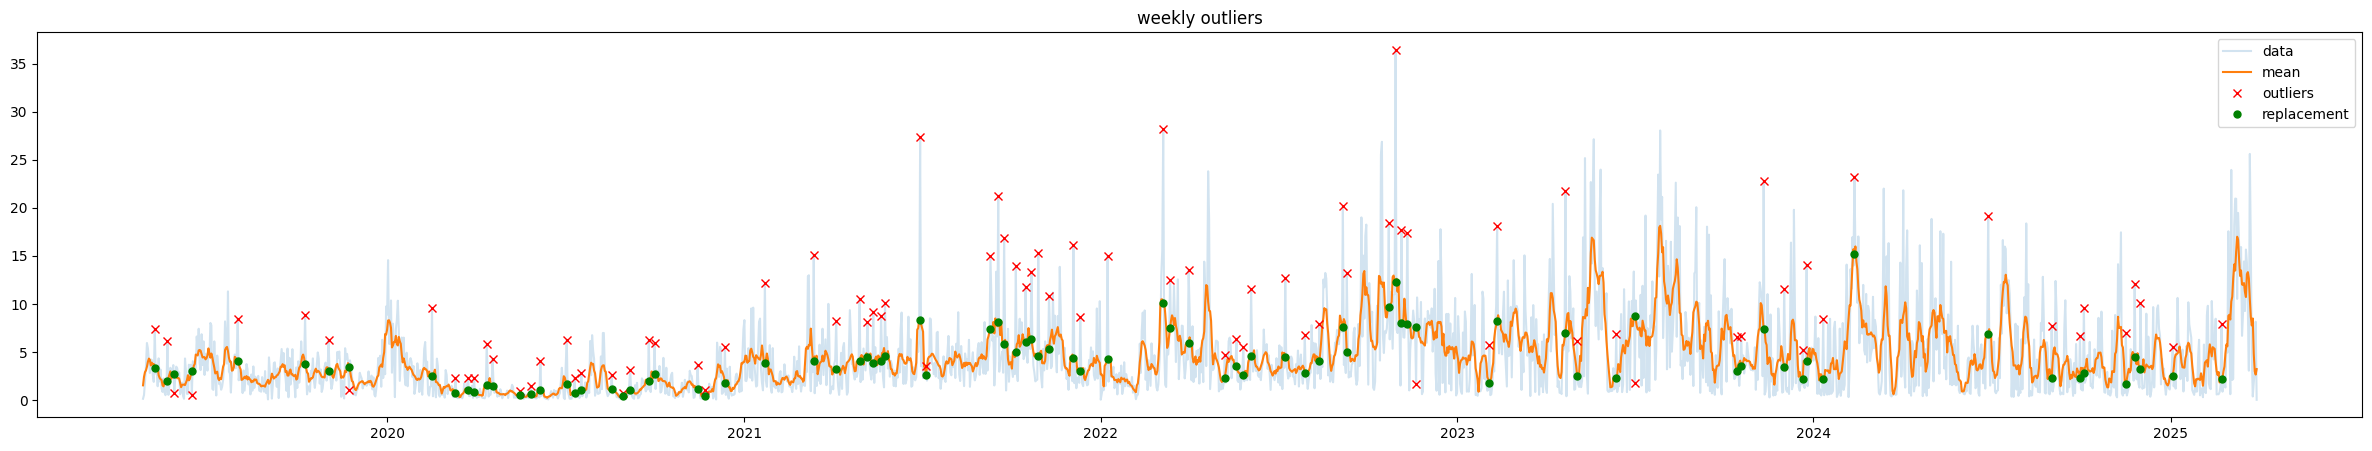

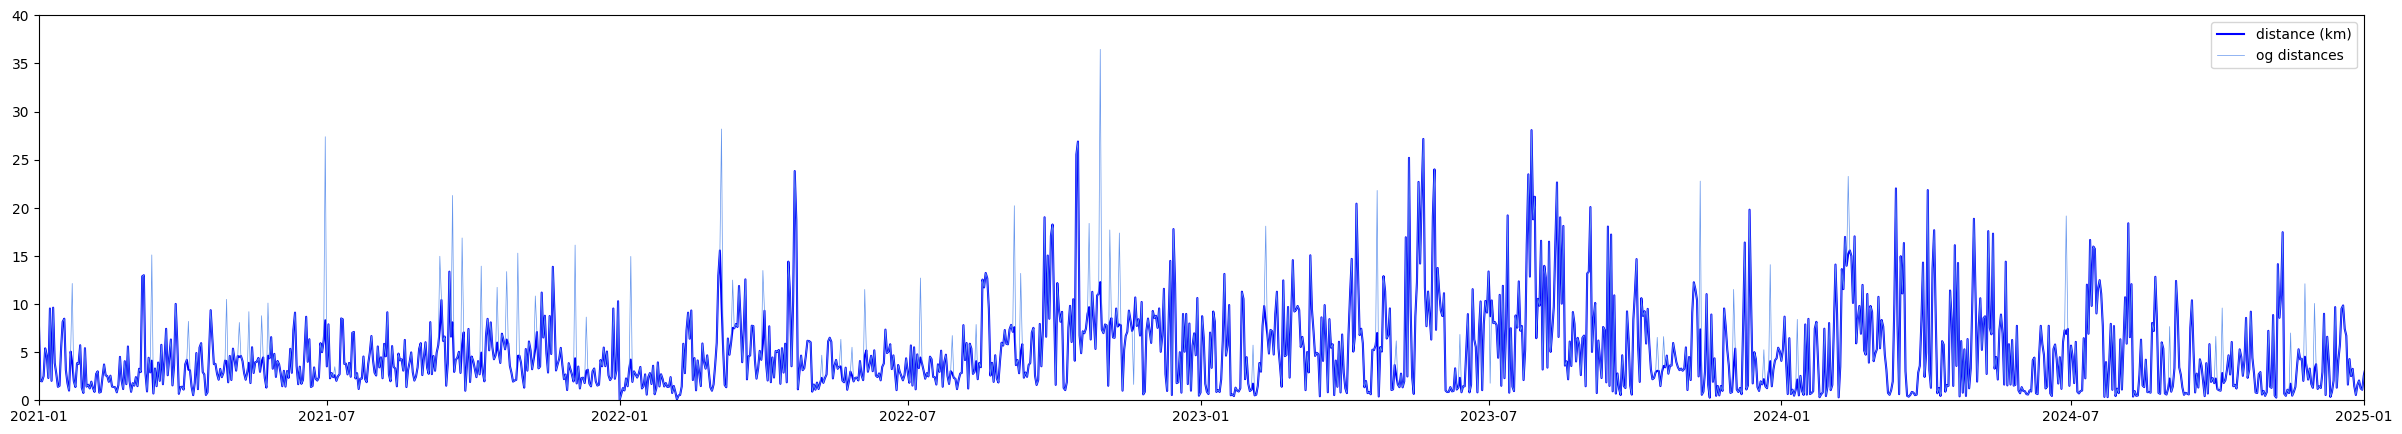

In [301]:
# weekly outliers
slim_wk_dist = zscore(distance_travelled['km'], window=7, thresh=2)
z, avg, std, m = zscore(distance_travelled['km'], window=7, thresh=2, return_all=True)
print(len(distance_travelled.loc[~m, :])/len(distance_travelled)*100, '% samples removed as outliers (2 st. dvs)')

plot_outliers(distance_travelled, avg, m, slim_wk_dist)
plot_slim(slim_wk_dist, distance_travelled)

5.170821791320406 % samples removed as outliers (2 st. dvs)


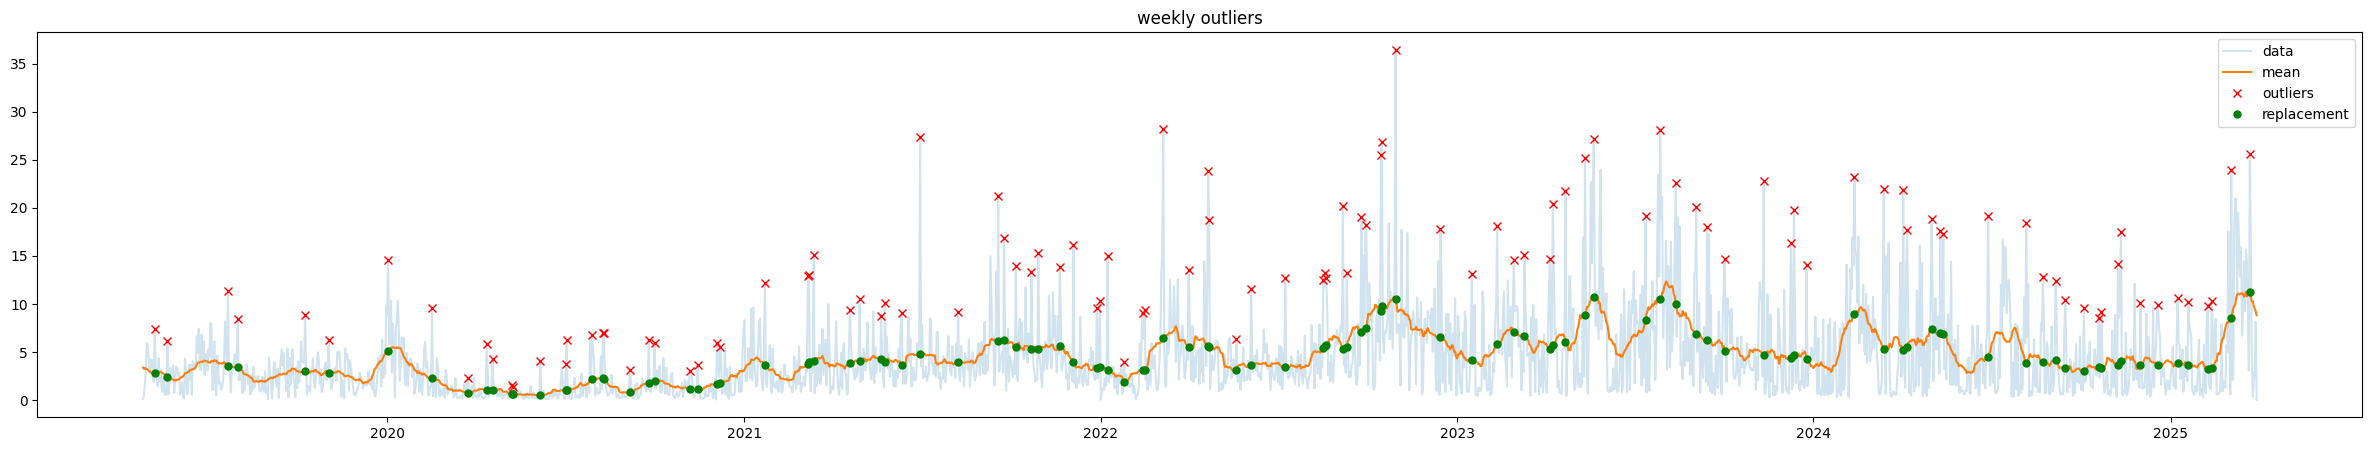

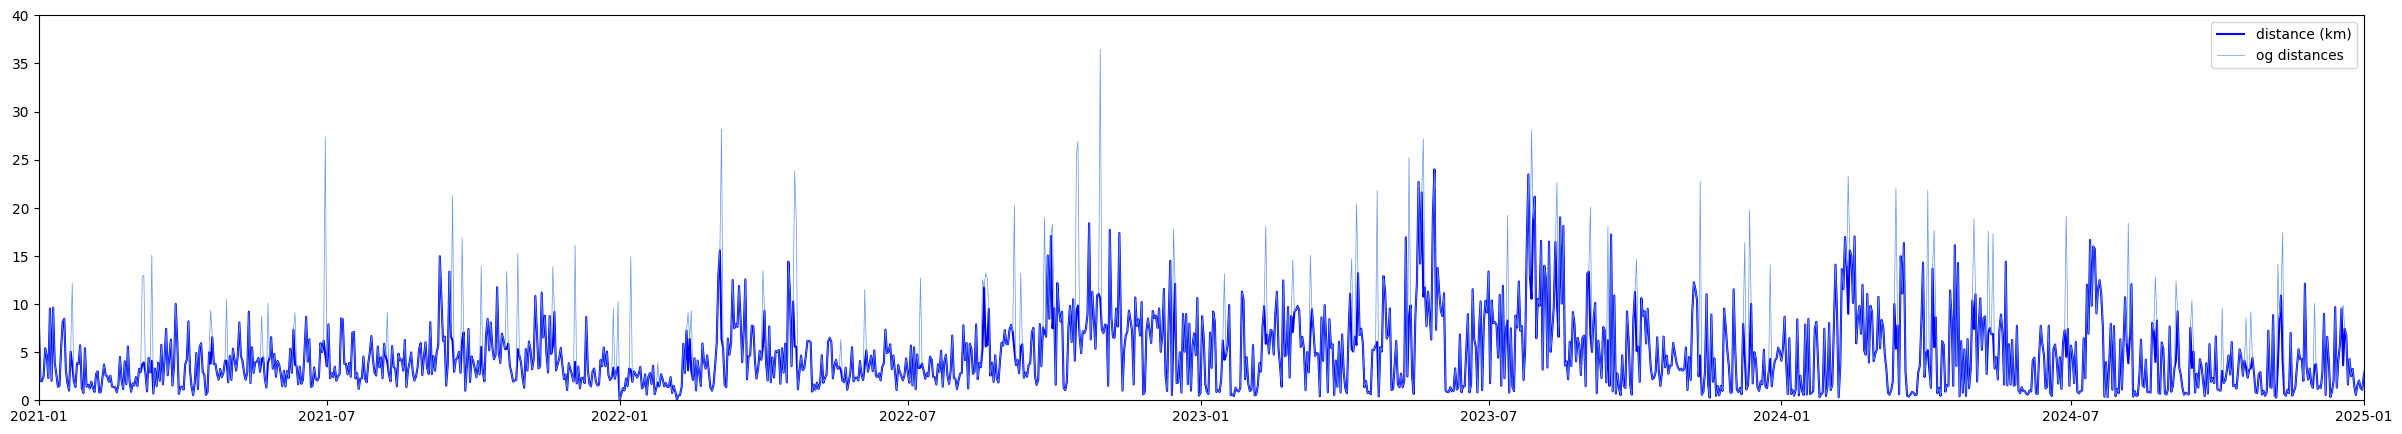

In [302]:
# monthly outliers
slim_mt_dist = zscore(distance_travelled['km'], window=30, thresh=2)
z, avg, std, m = zscore(distance_travelled['km'], window=30, thresh=2, return_all=True)
print(len(distance_travelled.loc[~m, :])/len(distance_travelled)*100, '% samples removed as outliers (2 st. dvs)')

plot_outliers(distance_travelled, avg, m, slim_mt_dist)
plot_slim(slim_mt_dist, distance_travelled)

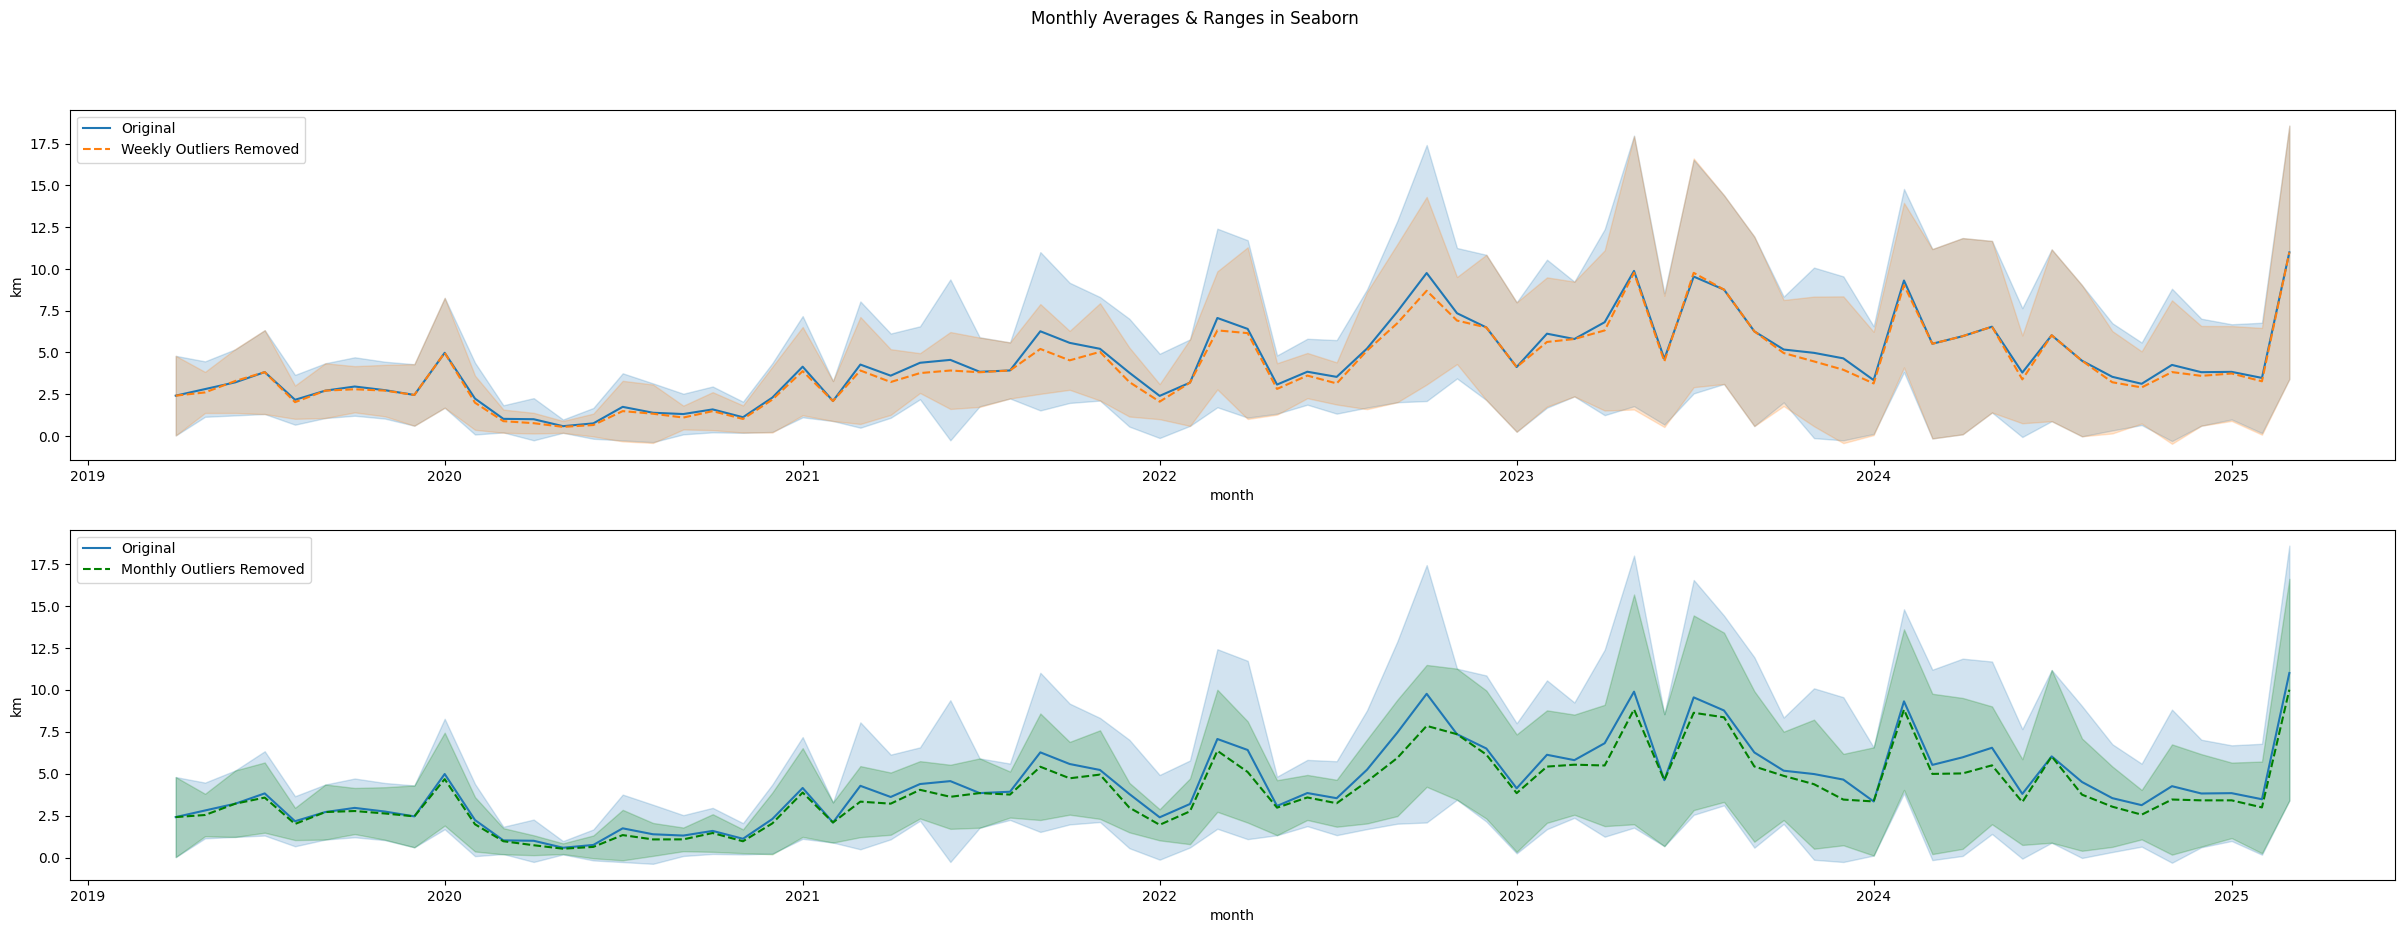

In [ ]:
sns_df = distance_travelled.copy()
sns_df['wkly_out'] = slim_wk_dist
sns_df['monthly_out'] = slim_mt_dist

sns_df.reset_index(inplace=True)
sns_df['month'] = [np.datetime64(d, 'M') for d in sns_df['date']]

fig, ax = plt.subplots(2, figsize=(30,10))

sns.lineplot(data=sns_df, x='month', y='km', errorbar='sd', ax=ax[0], label='Original')
sns.lineplot(data=sns_df, x='month', y='wkly_out', errorbar='sd', ax=ax[0],
             label='Weekly Outliers Removed', linestyle='dashed')

sns.lineplot(data=sns_df, x='month', y='km', errorbar='sd', ax=ax[1], label='Original')
sns.lineplot(data=sns_df, x='month', y='monthly_out', errorbar='sd', ax=ax[1],
             label='Monthly Outliers Removed', linestyle='dashed', color='green')
plt.legend()
plt.suptitle('Monthly Averages & Ranges in Seaborn')
plt.show()

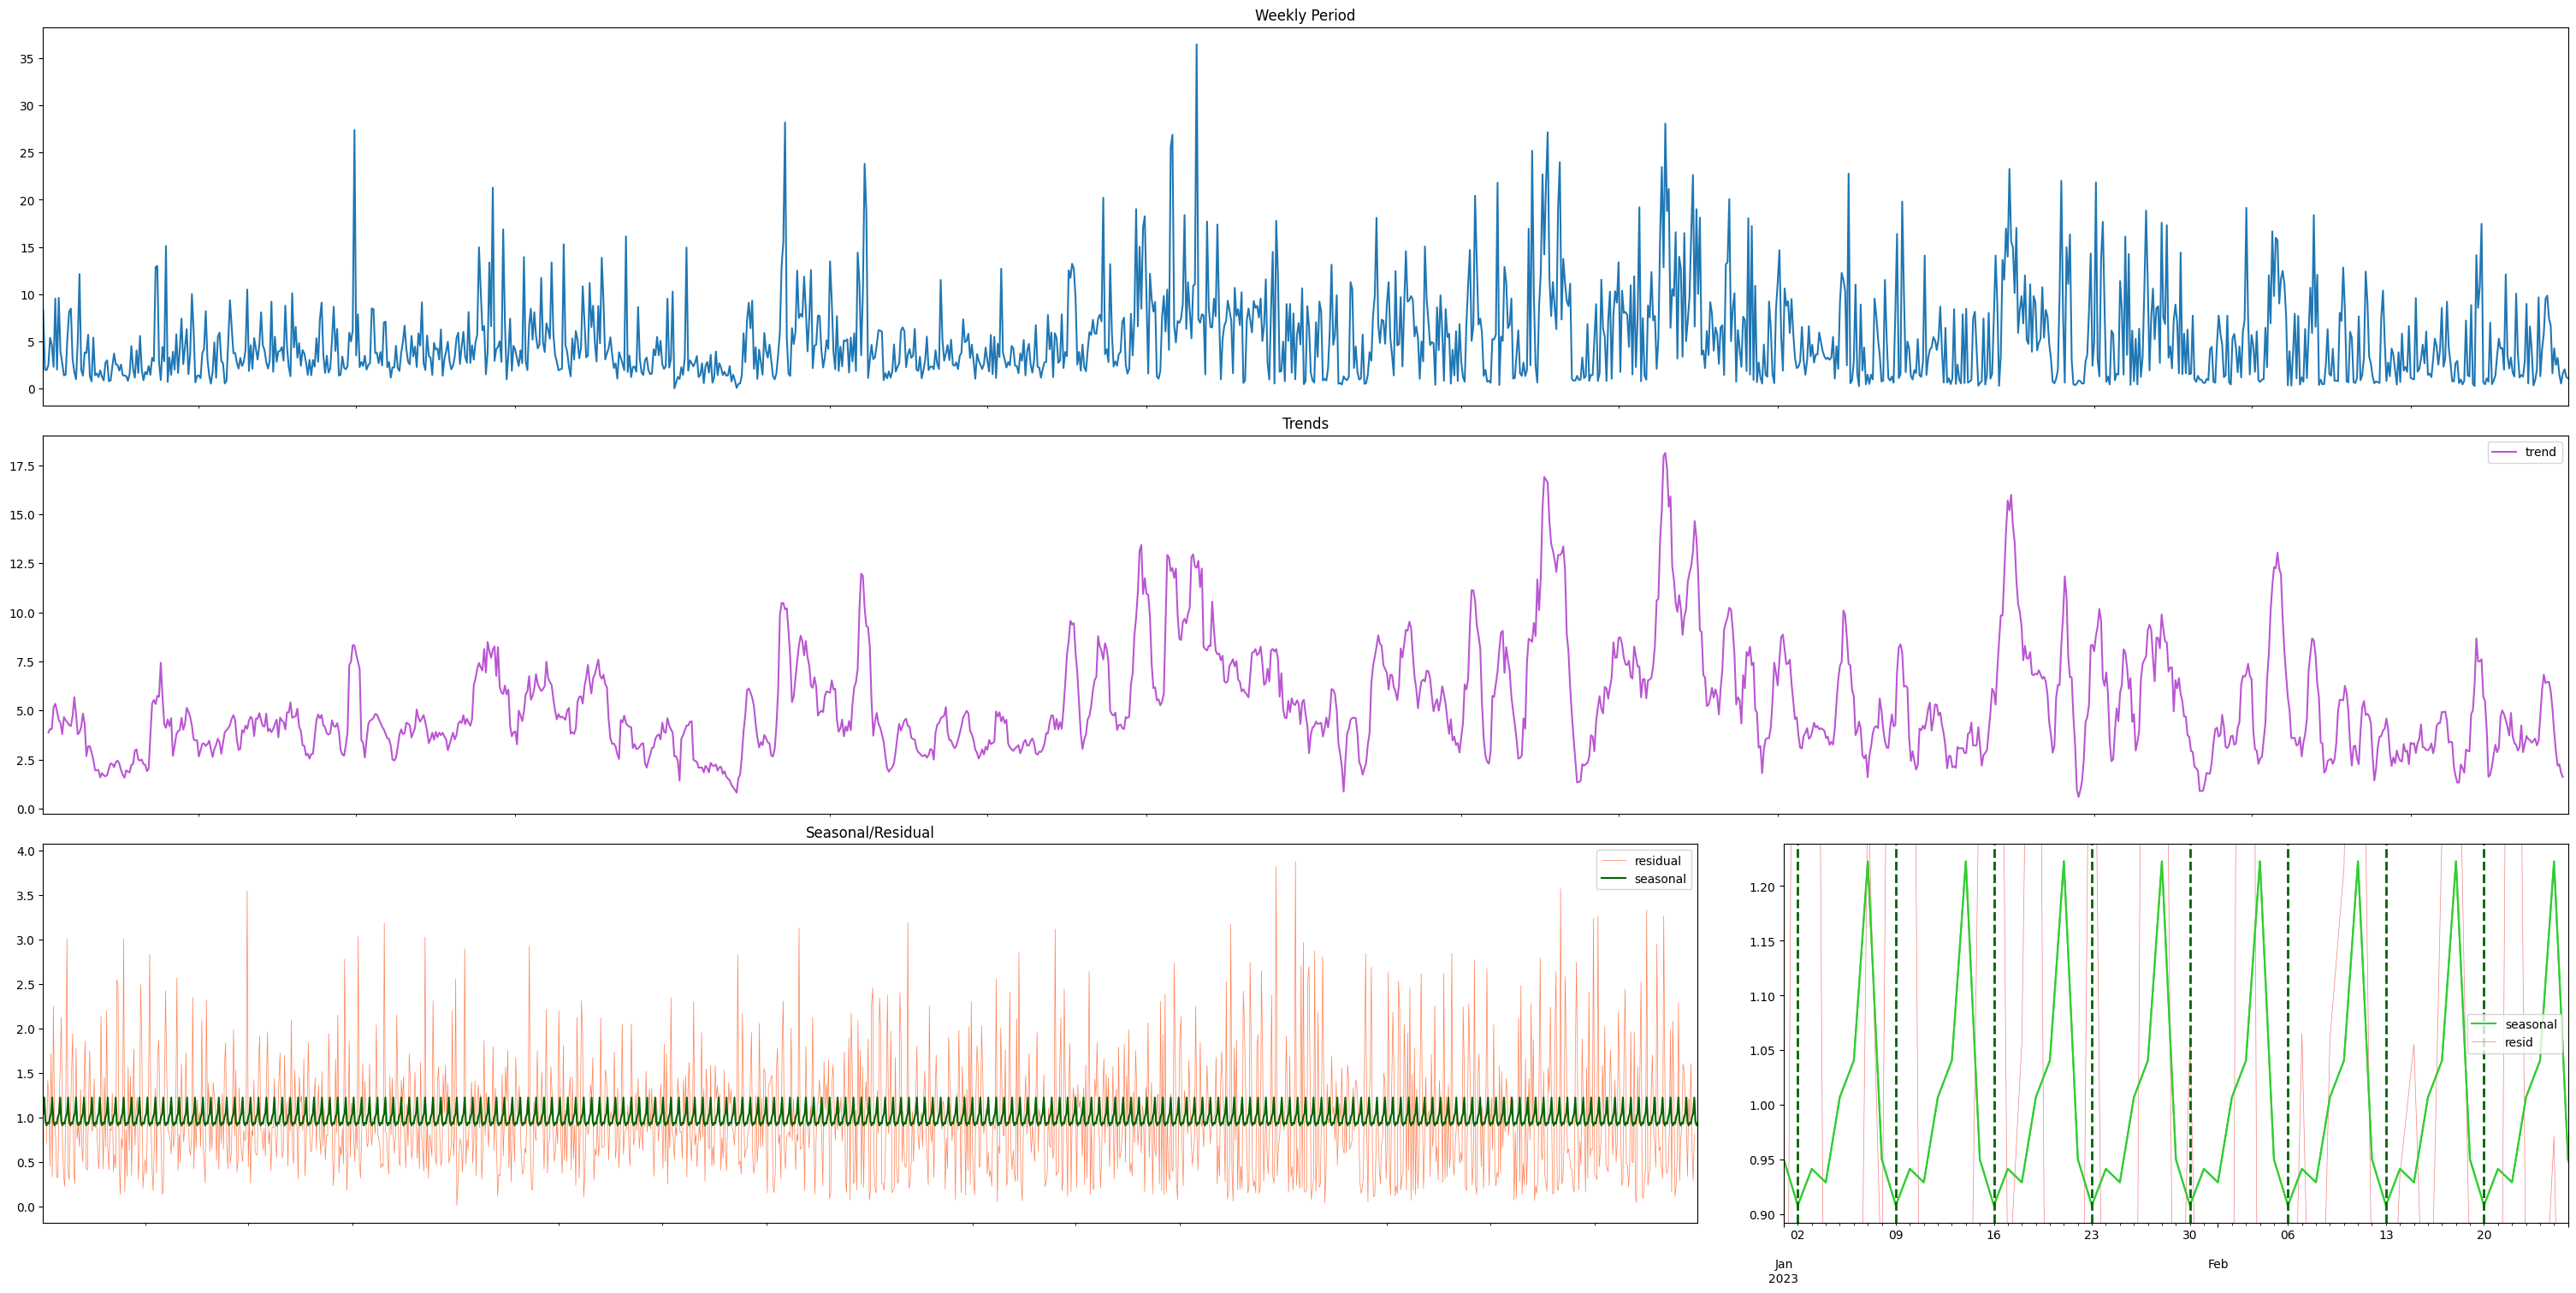

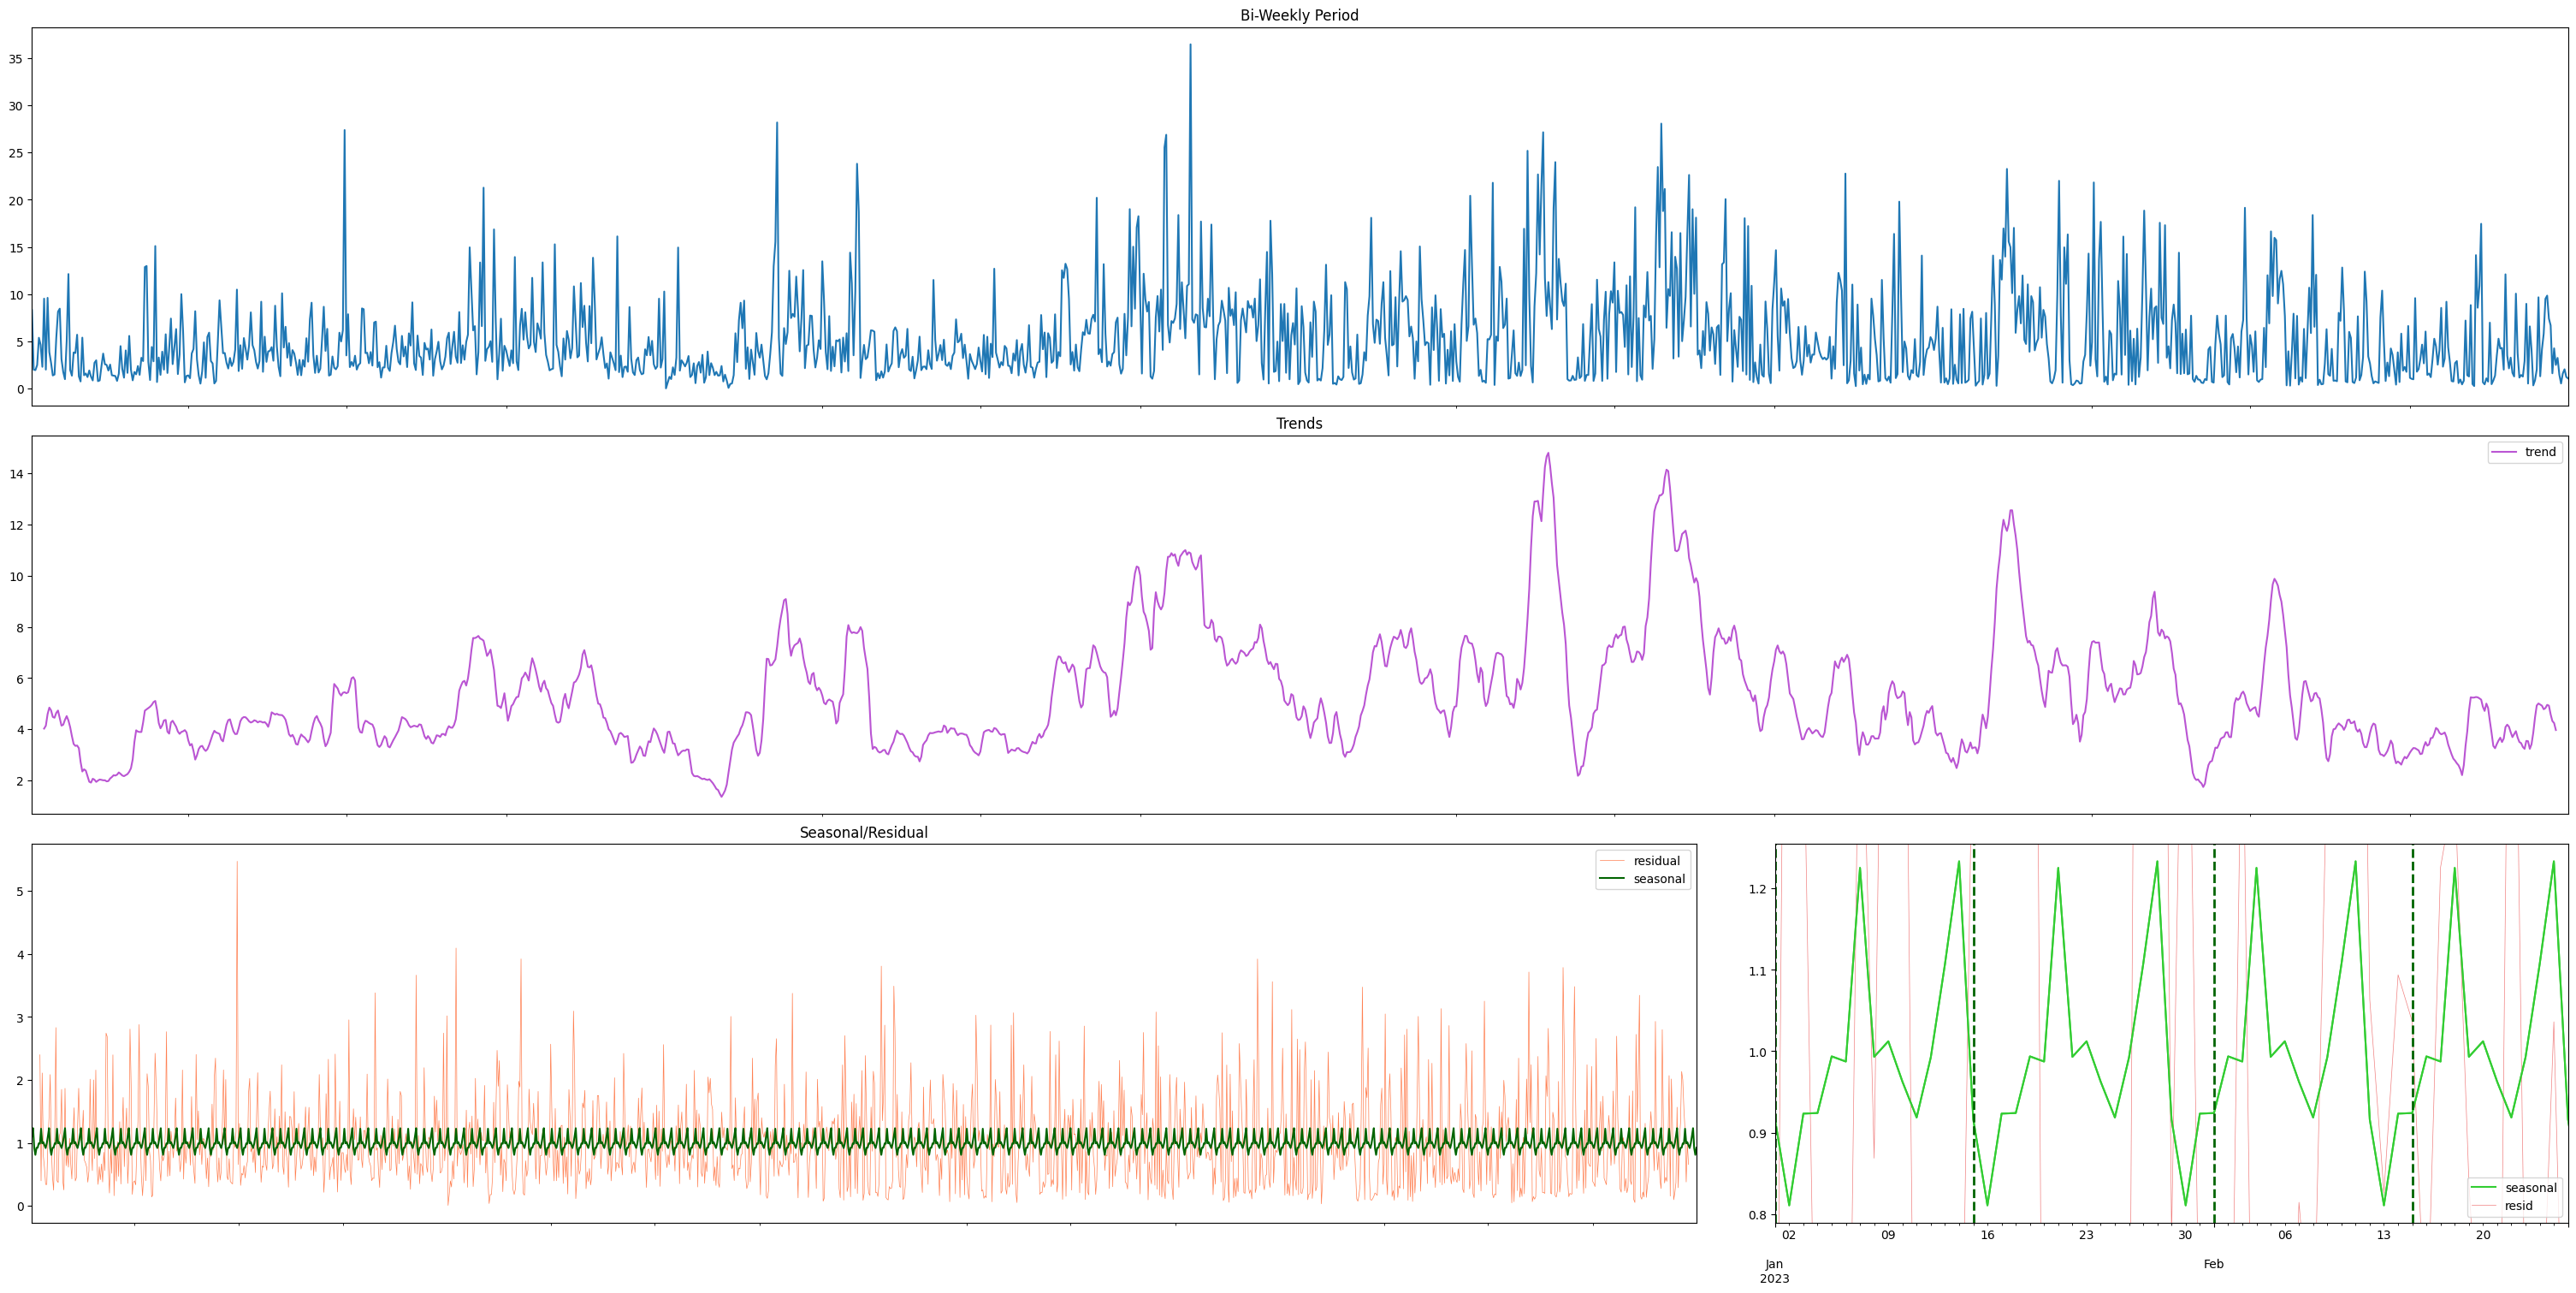

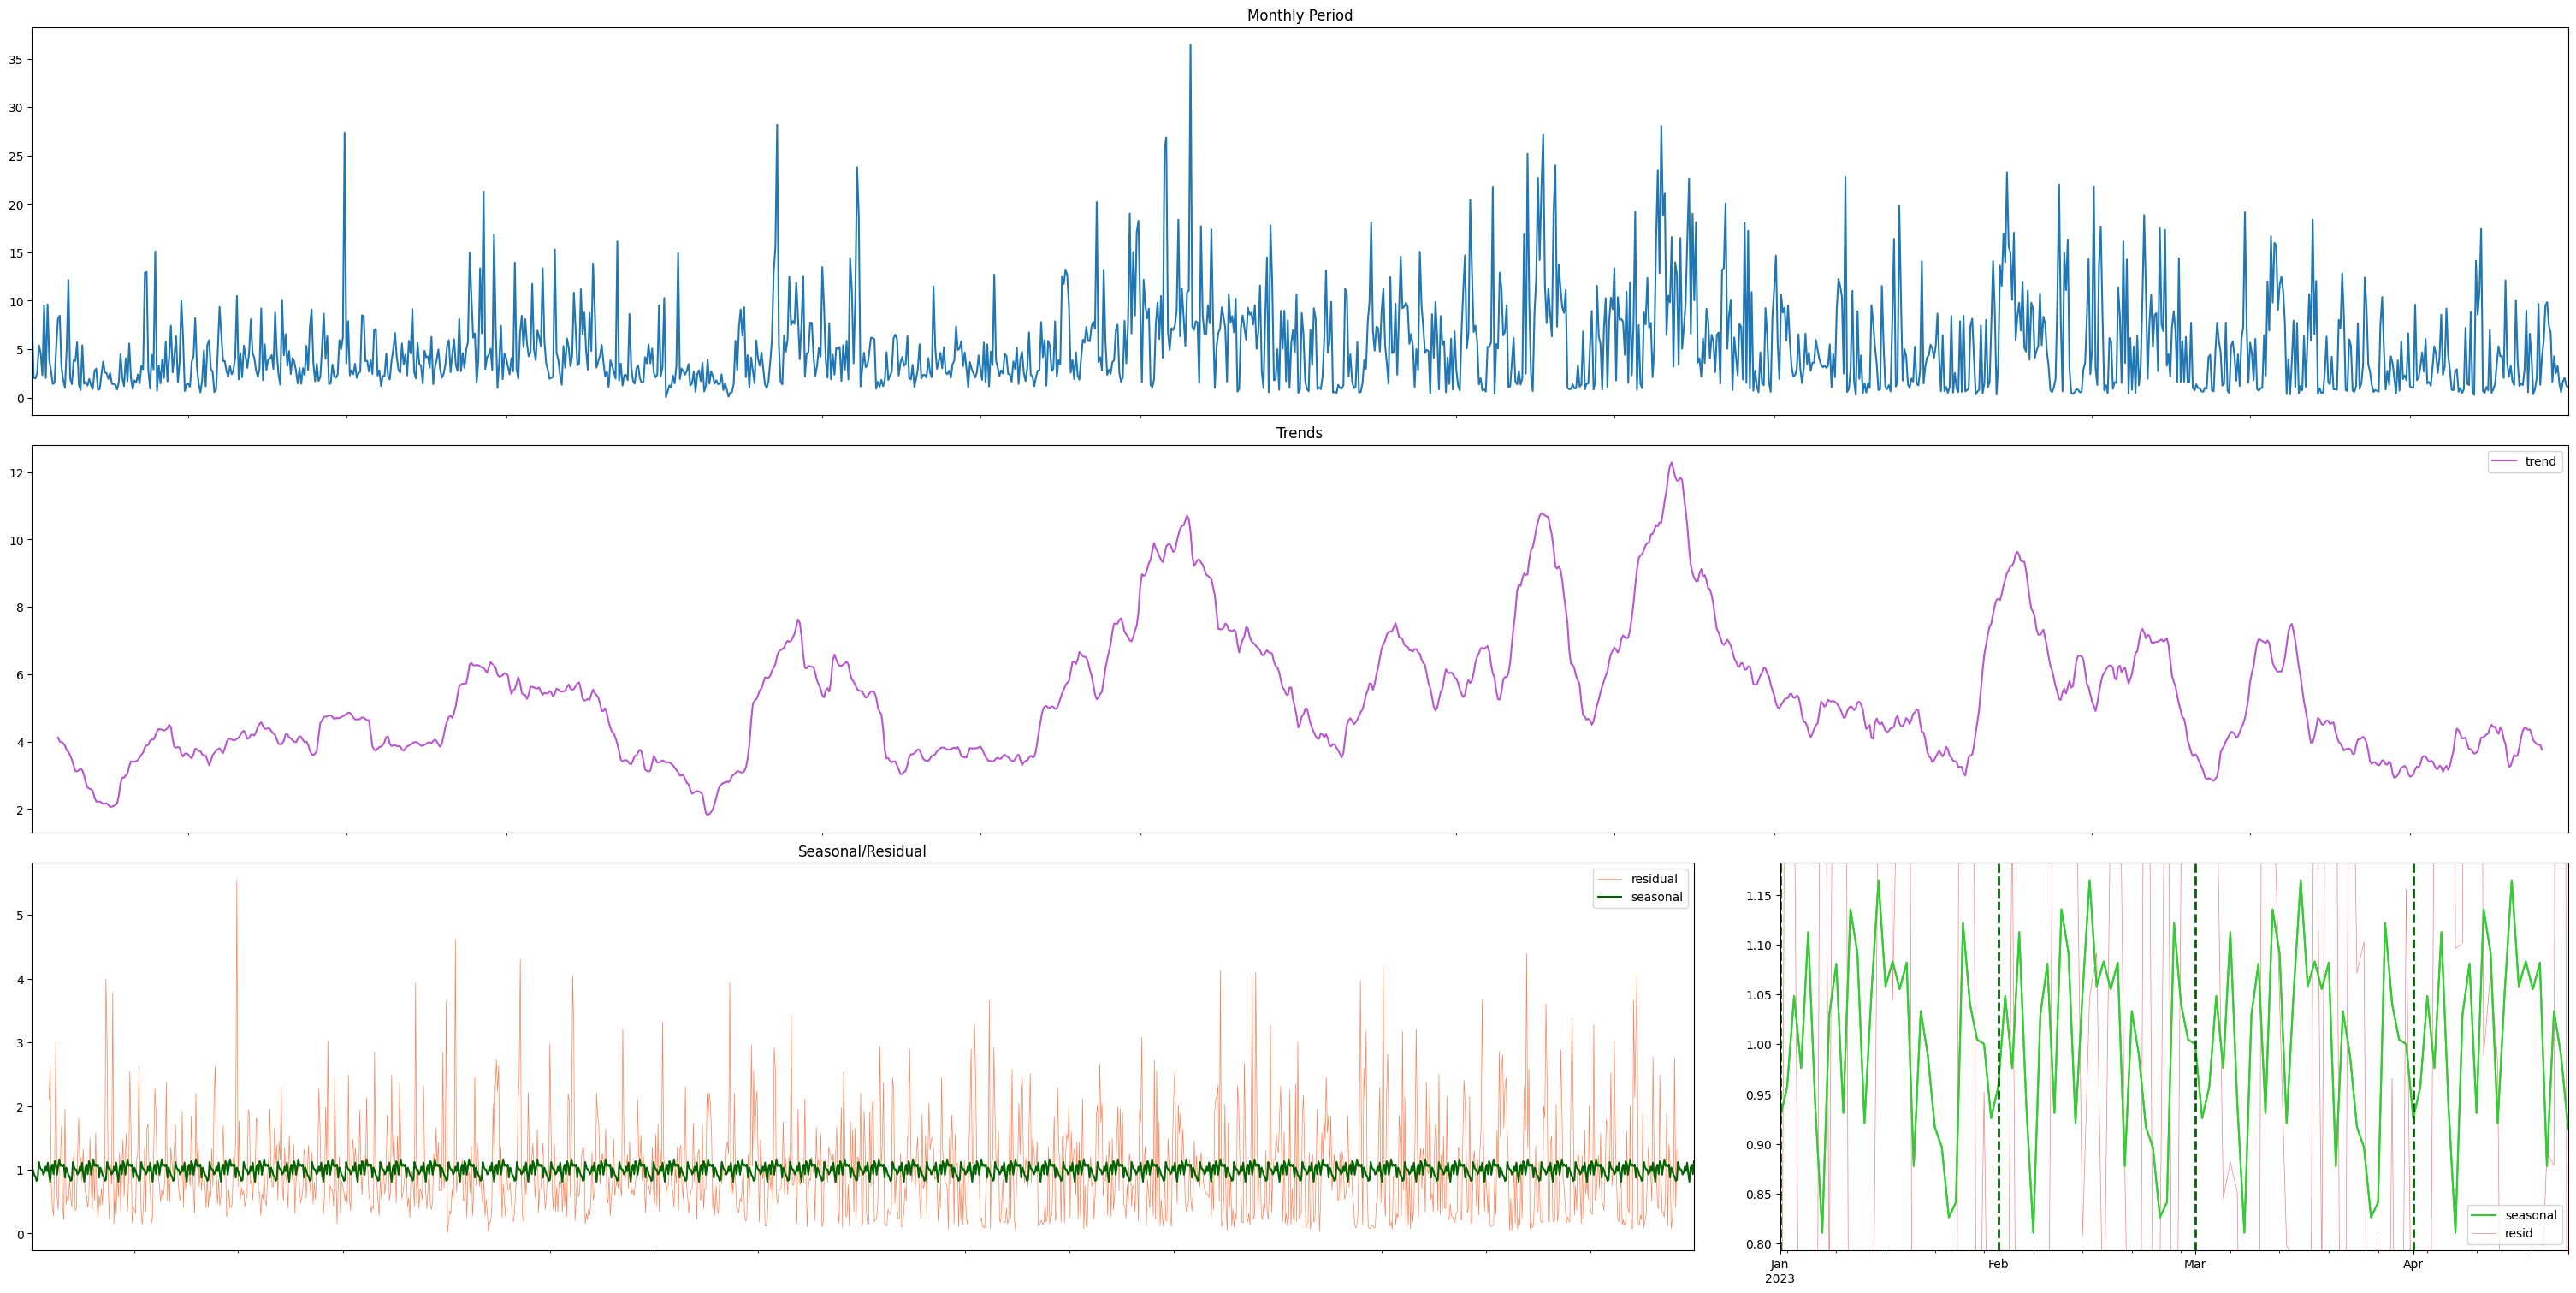

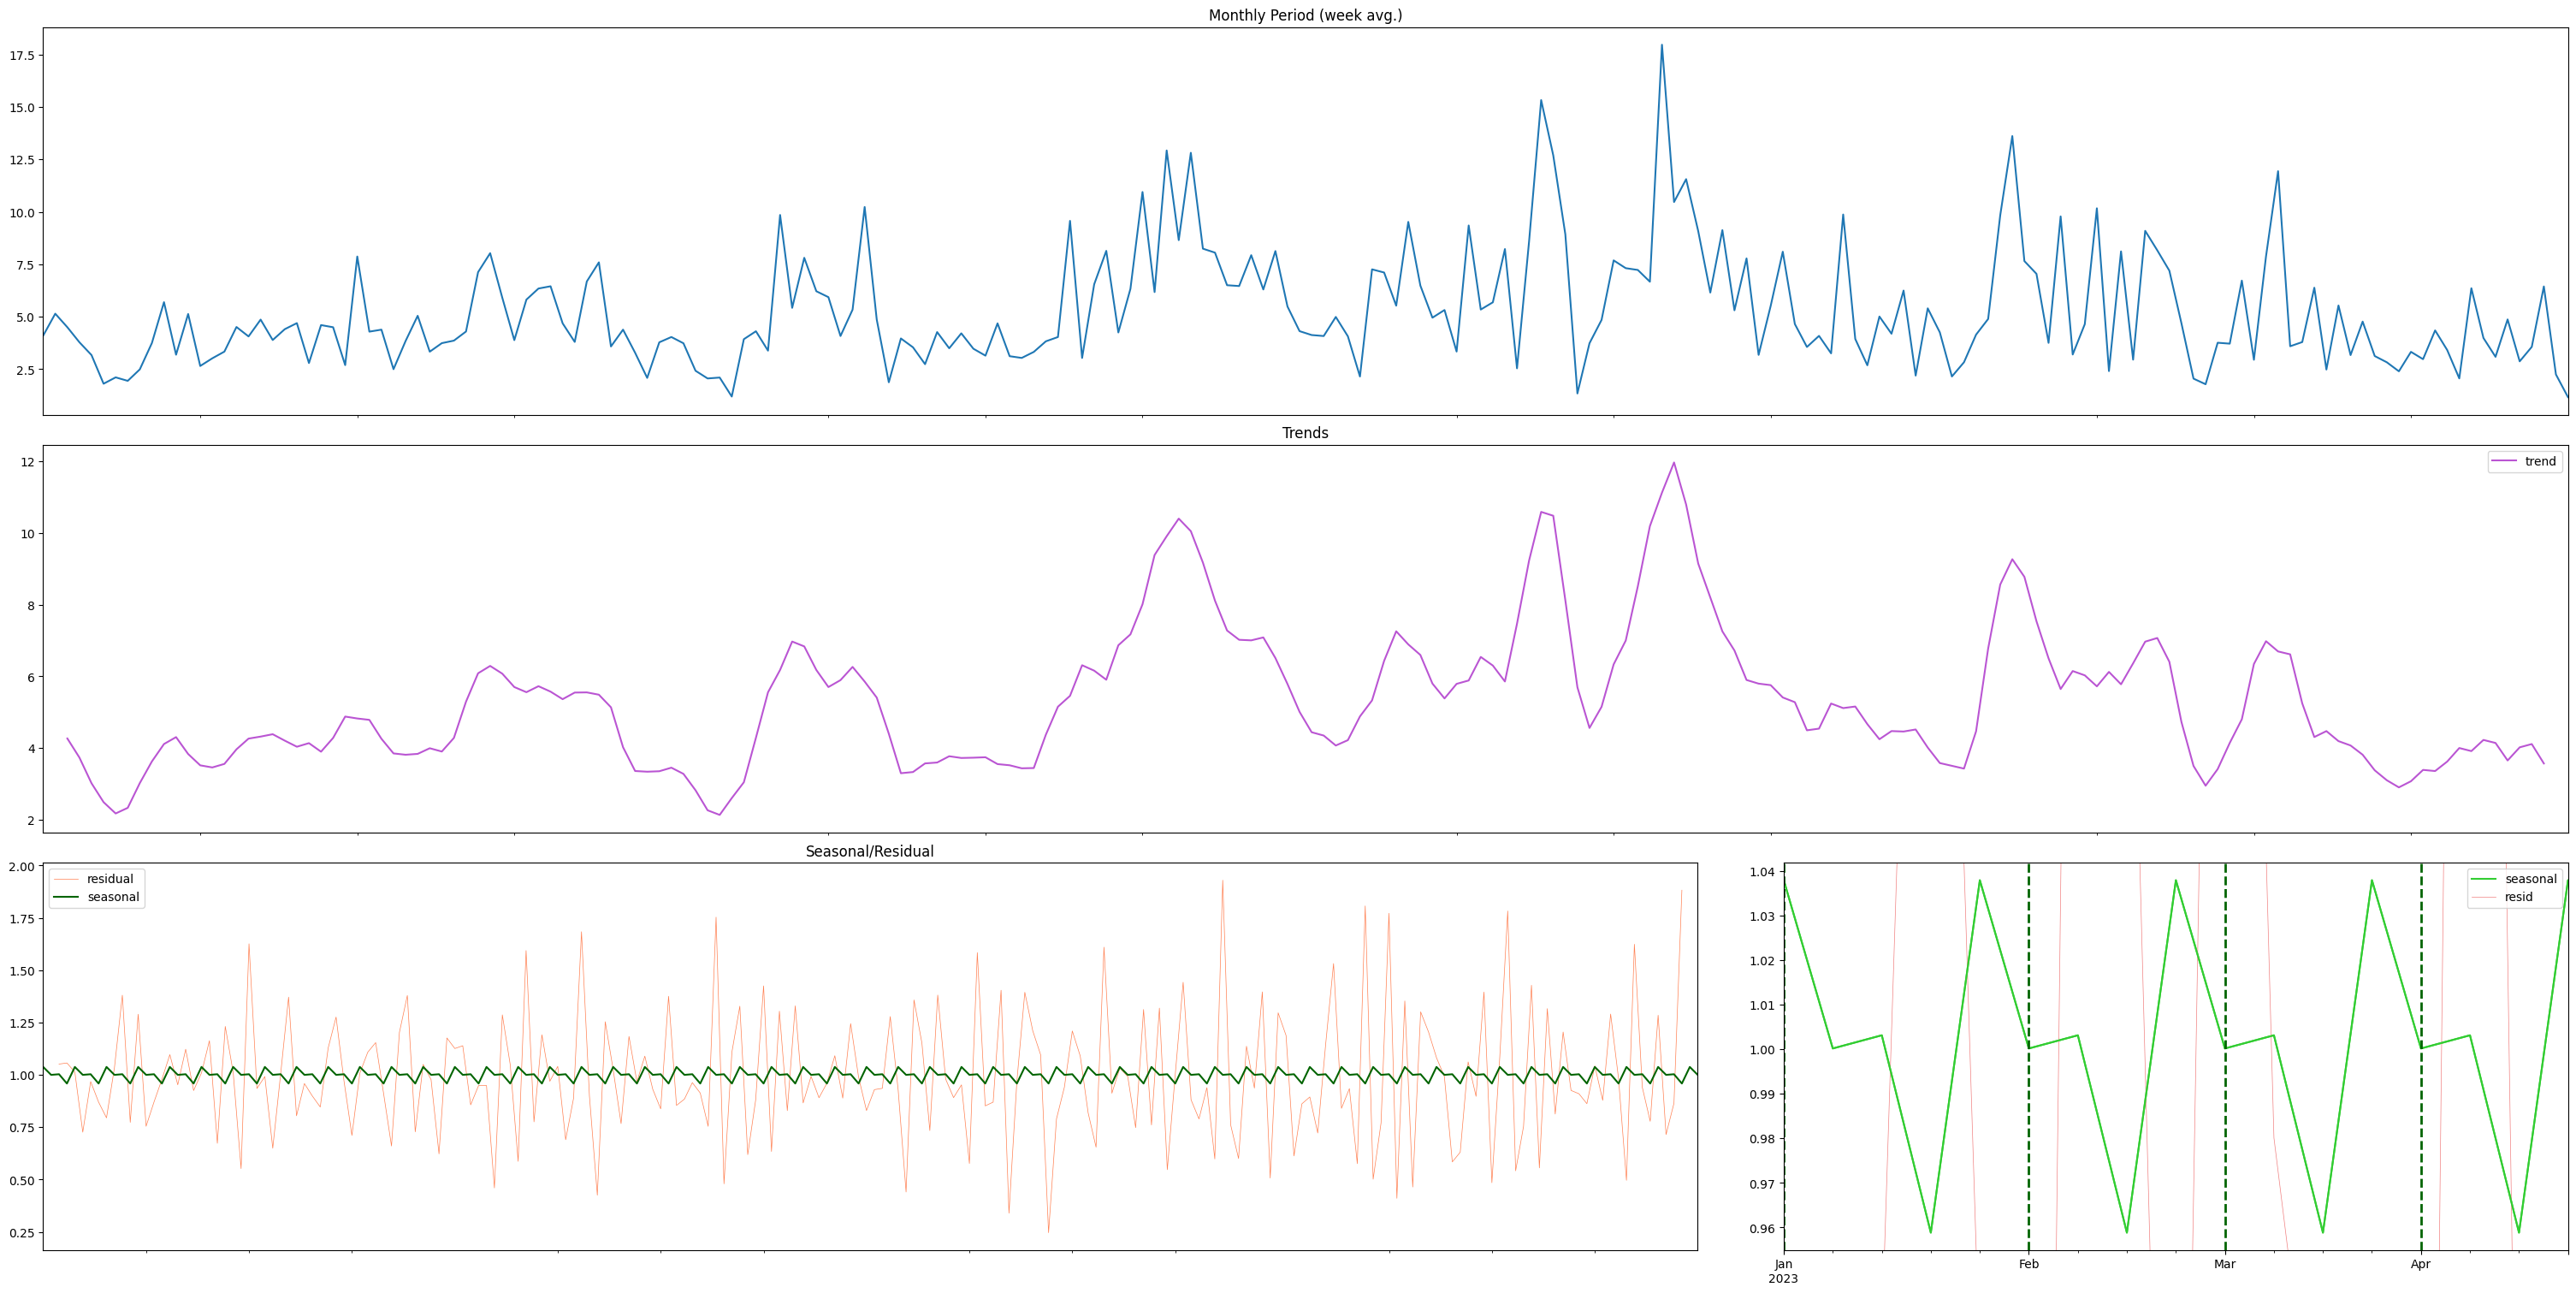

In [227]:
def decomp(series, period_name, period=0, months=2):
    if period != 0:
        mult_decomp = seasonal_decompose(series, model='multiplicative', period=period)
    else:
        mult_decomp = seasonal_decompose(series, model='multiplicative')

    fig = plt.figure(constrained_layout=True, figsize=(30,15))
    gs = fig.add_gridspec(3, 3)
    ax0 = fig.add_subplot(gs[0, :])
    ax1 = fig.add_subplot(gs[1, :])
    ax2 = fig.add_subplot(gs[2, 0:2])
    ax3 = fig.add_subplot(gs[2, 2])

    mult_decomp.observed.plot(ax=ax0, xlabel='')
    ax0.set_xticks([])
    ax0.set_title(period_name)

    mult_decomp.trend.plot(ax=ax1, xlabel='', xticks=[], color='mediumorchid')
    ax1.set_title('Trends')
    ax1.legend()

    mult_decomp.resid.plot(ax=ax2, xlabel='', xticks=[], color='coral', label='residual', linewidth=0.5)
    mult_decomp.seasonal.plot(ax=ax2, xlabel='', xticks=[], color='darkgreen', label='seasonal')
    ax2.set_title('Seasonal/Residual')
    ax2.legend()

    mult_decomp.seasonal.plot(ax=ax3, xlabel='', color='limegreen')
    bounds = ax3.get_ybound()
    mult_decomp.resid.plot(ax=ax3, xlabel='', color='lightcoral', linewidth=0.5)
    mult_decomp.seasonal.plot(ax=ax3, xlabel='', color='limegreen', label='')
    x1 = np.datetime64('2023-01-01')
    x2 = x1 + np.timedelta64(months*4, 'W')
    if period == 7:
        f = 'W-MON'
    elif period in [14, 2]:
        f = 'SMS'
    else:
        f = 'MS'
    lines=pd.date_range(start=x1,end=x2, freq=f)
    ax3.vlines(lines, bounds[0], bounds[1], colors='darkgreen', linestyles='dashed', linewidth=2)
    ax3.set_xbound(x1, x2)
    ax3.set_ybound(bounds)
    ax3.legend()

    plt.show()


decomp(four_years_df['km'], 'Weekly Period', period=7)

f7_weekly = four_years_df['km'].resample('W').mean()
decomp(four_years_df['km'], 'Bi-Weekly Period', period=14)

decomp(four_years_df['km'], 'Monthly Period', period=30, months=4)
decomp(f7_weekly, 'Monthly Period (week avg.)', period=4, months=4)


In [ ]:
timeseries = four_years_df.copy()
timeseries['day'] = timeseries.index.day
monthly_ts = []

fig, ax = plt.subplots(figsize=[20, 10])
sns_blue = sns.color_palette(as_cmap=True)
for day, ts in timeseries.groupby("day"):
    ts = ts.reset_index()["daily_km"]
    monthly_ts.append(ts)
    ts.plot(alpha=0.1, ax=ax, label='_no_legend_')
    plt.xticks(ticks=np.linspace(0, 50, 30), labels=np.arange(1,31,1))


pd.concat(monthly_ts, axis=1).mean(axis=1).plot(
    ax=ax, color="blue", label="mean", legend=True
)

plt.tight_layout()

In [ ]:
timeseries = four_years_df.copy()
timeseries['day'] = timeseries.index.day


In [ ]:
monthly_ts = []

fig, ax = plt.subplots(figsize=[20, 10])
sns_blue = sns.color_palette(as_cmap=True)
for day, ts in timeseries.groupby("day"):
    ts = ts.reset_index()["daily_km"]
    monthly_ts.append(ts)
    ts.plot(alpha=0.1, ax=ax, label='_no_legend_')
    plt.xticks(ticks=np.linspace(0, 50, 30), labels=np.arange(1,31,1))


pd.concat(monthly_ts, axis=1).mean(axis=1).plot(
    ax=ax, color="blue", label="mean", legend=True
)

plt.tight_layout()

In [295]:
# xs = monthly_means.index.to_numpy(dtype='datetime64[D]')
# edges = np.append(xs, xs[-1] + np.timedelta64(30, 'D'))

# fig, ax = plt.subplots(figsize=(30,5))

# ax.stairs(monthly_means['mean_km'], edges, label='mean_km', linewidth=1.5, color='blue')

# ax.bar(distance_travelled.index, distance_travelled['km'], label='daily sums', color='gray', alpha=0.5)

# upperlimits = [True, False] * (len(monthly_means)//2)
# lowerlimits = [False, True] * (len(monthly_means)//2)
# ax.errorbar(monthly_means.index + np.timedelta64(10, 'D'), monthly_means['mean_km'],
#             yerr=monthly_means['std_km'], uplims=upperlimits, lolims=lowerlimits,
#             color='darkred', linestyle='none')

# ax.vlines(year_starts, 0, 35, colors='green', linestyles='dashed', linewidth=2)

# ax.set_title('Daily Sums and Monthly Averages')
# ax.set_ybound(-0.5, 30)
# ax.set_xbound(edges[1], edges[-1])
# plt.legend()
# plt.show()